In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from data_preprocessing import preprocess_data
from data_preprocessing import remove_correlated_variables
from data_preprocessing import cap_outliers
from data_loading import load_data
from approval_matrix import plot_approval_matrix
from model_evaluation import cross_val_pr_curve,tune_hyperparameters

In [8]:
train_data_path="/Users/heba/Desktop/Erdos/Training Dataset A_R-384891_Candidate Attach #1_PresSE_SRF #1142.csv"
test_data_path="/Users/heba/Desktop/Erdos/Evaluation Dataset B_R-384891_Candidate Attach #2_PresSE_SRF #1142.csv"
train_df, test_df = load_data(train_data_path,test_data_path)
X_train_processed, y_train, X_test_processed, y_test=preprocess_data(train_df, test_df)

/Users/heba/Desktop/data-science-spring-2025/project/NEW/data_preprocessing.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28. 17. 26. ... 73. 33. 56.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].clip(upper=upper_limit)


In [9]:
# Initialize individual classifiers

best_params_lr={'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

best_params_rf={'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2\
                , 'n_estimators': 300}
best_params_xgb={'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, \
                 'scale_pos_weight': 0.3544383149448345, 'subsample': 0.7}

# Define the base models
rf_clf_stack = RandomForestClassifier(**best_params_rf)

xgb_clf_stack =  xgb.XGBClassifier(**best_params_xgb)

# Define the meta-learner
meta_learner_logreg = LogisticRegression(**best_params_lr)

# Update Stacking Classifier with Logistic Regression as the meta-learner
stacking1_clf = StackingClassifier(
    estimators=[('rf', rf_clf_stack), ('xgb', xgb_clf_stack)],
    final_estimator=meta_learner_logreg,
    cv=3,  # Cross-validation for stacking
    n_jobs=-1
)

# Fit the ensemble model on training data
stacking1_clf.fit(X_train_processed, y_train)

StackingClassifier(cv=3,
                   estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20,
                                                       n_estimators=300)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1.0, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=Non...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=10,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression(C=0.1,
                                                      class_weight='balanced',
                                                      penalty='l1',
                                                      solver='liblinear'),
                   n_jobs=-1)

Cross-Validation Precision Scores: [0.9396875  0.94101067 0.93959021]
Mean Precision Score: 0.9400961234021336
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.75      0.69      5654
           1       0.91      0.85      0.88     15952

    accuracy                           0.82     21606
   macro avg       0.77      0.80      0.78     21606
weighted avg       0.84      0.82      0.83     21606



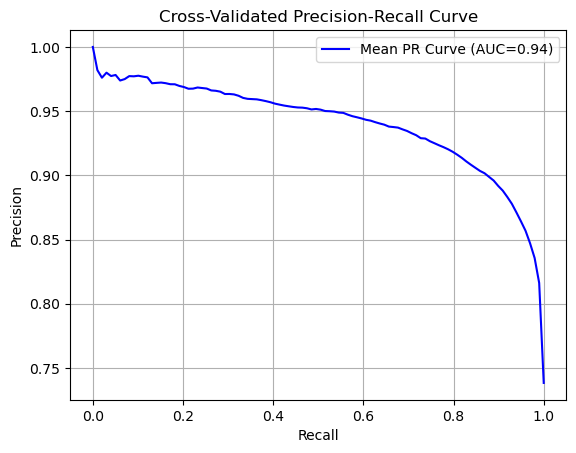

Mean Precision-Recall AUC: 0.9408


In [10]:
from model_evaluation import evaluate_models
evaluate_models(stacking1_clf, X_train_processed, y_train,'average_precision')

**Feature Importance Using Permuatiuon**


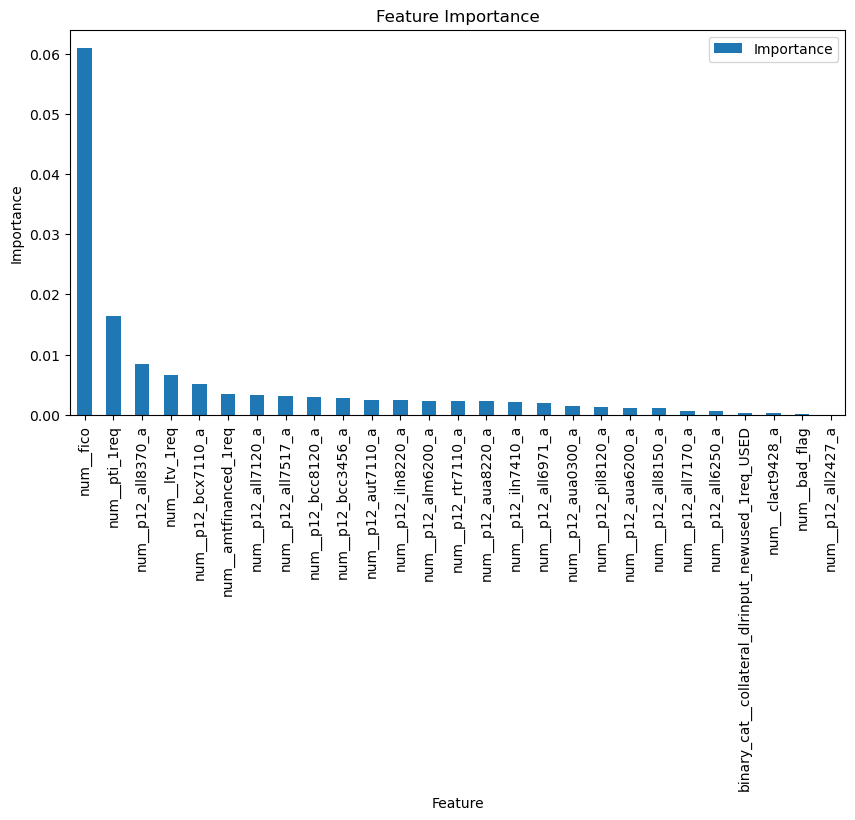

In [11]:
from model_evaluation import feature_importance
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
feature_importance(stacking1_clf, X_train_processed, y_train,'average_precision')

In [12]:
y_pred_stacking_test = stacking1_clf.predict(X_test_processed)

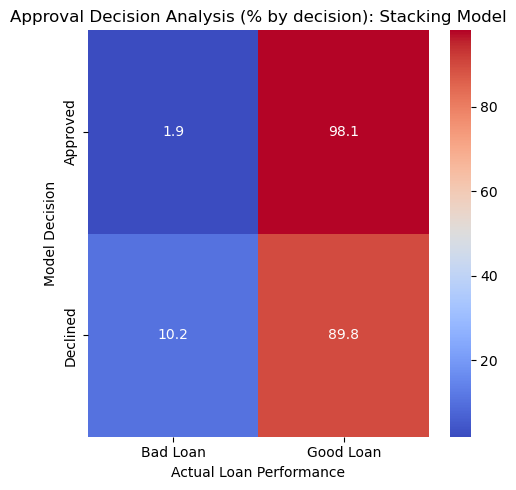

In [13]:
plot_approval_matrix(y_pred_stacking_test,pd.read_csv(test_data_path)['bad_flag'], 'Stacking Model')

In [14]:
print("Stacking model approval rate: ", y_pred_stacking_test.mean())

Stacking model approval rate:  0.6757407407407408


In [15]:
gender_aprv = pd.DataFrame({'Gender': pd.read_csv(test_data_path)['Gender'], 'Model_Aprv': y_pred_stacking_test, 'True_Aprv': pd.read_csv(test_data_path)['aprv_flag']})
gender_aprv.groupby(['Gender']).mean()

,Model_Aprv,True_Aprv
Gender,,
Female,0.678571,0.737654
Male,0.677689,0.749739
Undefined,0.629344,0.683398


In [16]:
race_aprv = pd.DataFrame({'Race': pd.read_csv(test_data_path)['Race'], 'Model_Aprv': y_pred_stacking_test, 'True_Aprv': pd.read_csv(test_data_path)['aprv_flag']})
race_aprv.groupby(['Race']).mean()

,Model_Aprv,True_Aprv
Race,,
Asian,0.733813,0.755396
Black,0.660274,0.724658
Hispanic,0.657423,0.721044
Other,0.648794,0.718499
White,0.687926,0.756480
